In [25]:
import numpy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams, cm
rcParams['font.family']='serif'
rcParams['font.size']=16

In [26]:
def ftcs(T, nt, alpha, dt, dx, dy):
    j_mid = int((numpy.shape(T)[0])/2)
    i_mid = int((numpy.shape(T)[1])/2)
    for n in range(nt):
        Tn = T.copy()
        T[1:-1, 1:-1] = Tn[1:-1, 1:-1]+alpha*\
        (dt/dy**2*(Tn[2:, 1:-1] - 2*Tn[1:-1, 1:-1]+ Tn[:-2, 1:-1])+\
         dt/dx**2*(Tn[1:-1, 2:] - 2*Tn[1:-1, 1:-1]+ Tn[1:-1, :-2]))
        T[-1, :]=T[-2, :]
        T[:, -1] = T[:, -2]
        
        if T[j_mid, i_mid]>=70:
            print("Center of plate reached 70C at time{0:.2f}s.", format(dt*n))
            break
    if T[j_mid, i_mid]<70:
        print ("Center has not reached 70C yet, it is only {0:, .2f}C.". format(T[j_mid, i_mid]))
    return T

In [27]:
L = 1.0e-2
H = 1.0e-2

nx = 21
ny = 21
nt = 500

dx = L/(nx-1)
dy = H/(ny-1)

x = numpy.linspace(0, L, nx)
y = numpy.linspace(0, H, ny)

alpha = 1e-4
Ti = numpy.ones((ny, nx))*20
Ti[0,:] = 100
Ti[:, 0] = 100

In [30]:
sigma = 0.25
dt = sigma*min(dx, dy)**2/alpha
T = ftcs(Ti.copy(), nt, alpha, dt, dx, dy)

Center of plate reached 70C at time{0:.2f}s. 0.159375


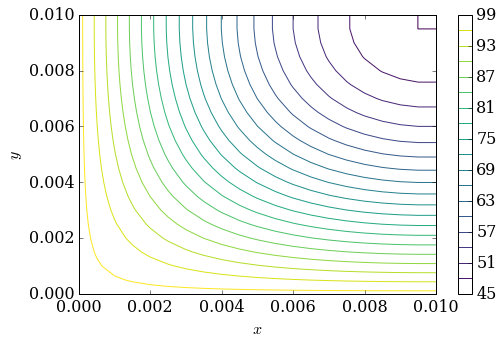

In [31]:
pyplot.figure(figsize=(8,5))
pyplot.contour(x, y, T, 20, cmap=cm.viridis)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar();

In [6]:
exit

In [1]:
clear

In [2]:
import numpy
from scipy.linalg import solve

In [3]:
def constructMatrix(nx, ny, sigma):
    A = numpy.zeros(((nx-2)*(ny-2), (nx-2)*(ny-2)))
    row_number = 0 #row counter
    for j in range(1, ny-1):
        for i in range(1, nx-1): 
           # Corners
            if i==1 and j==1: # Bottom left corner (Dirichlet down and left)
                A[row_number,row_number] = 1/sigma+4 # Set diagonal
                A[row_number,row_number+1] = -1      # fetch i+1
                A[row_number,row_number+nx-2] = -1   # fetch j+1
                
            elif i==nx-2 and j==1: # Bottom right corner (Dirichlet down, Neumann right)
                A[row_number,row_number] = 1/sigma+3 # Set diagonal
                A[row_number,row_number-1] = -1      # Fetch i-1
                A[row_number,row_number+nx-2] = -1   # fetch j+1
                
            elif i==1 and j==ny-2: # Top left corner (Neumann up, Dirichlet left)
                A[row_number,row_number] = 1/sigma+3   # Set diagonal
                A[row_number,row_number+1] = -1        # fetch i+1
                A[row_number,row_number-(nx-2)] = -1   # fetch j-1
                
            elif i==nx-2 and j==ny-2: # Top right corner (Neumann up and right)
                A[row_number,row_number] = 1/sigma+2   # Set diagonal
                A[row_number,row_number-1] = -1        # Fetch i-1
                A[row_number,row_number-(nx-2)] = -1   # fetch j-1
              
            # Sides
            elif i==1: # Left boundary (Dirichlet)
                A[row_number,row_number] = 1/sigma+4 # Set diagonal
                A[row_number,row_number+1] = -1      # fetch i+1
                A[row_number,row_number+nx-2] = -1   # fetch j+1
                A[row_number,row_number-(nx-2)] = -1 # fetch j-1
            
            elif i==nx-2: # Right boundary (Neumann)
                A[row_number,row_number] = 1/sigma+3 # Set diagonal
                A[row_number,row_number-1] = -1      # Fetch i-1
                A[row_number,row_number+nx-2] = -1   # fetch j+1
                A[row_number,row_number-(nx-2)] = -1 # fetch j-1
                
            elif j==1: # Bottom boundary (Dirichlet)
                A[row_number,row_number] = 1/sigma+4 # Set diagonal
                A[row_number,row_number+1] = -1      # fetch i+1
                A[row_number,row_number-1] = -1      # fetch i-1
                A[row_number,row_number+nx-2] = -1   # fetch j+1
                
            elif j==ny-2: # Top boundary (Neumann)
                A[row_number,row_number] = 1/sigma+3 # Set diagonal
                A[row_number,row_number+1] = -1      # fetch i+1
                A[row_number,row_number-1] = -1      # fetch i-1
                A[row_number,row_number-(nx-2)] = -1 # fetch j-1
                
            # Interior points
            else:
                A[row_number,row_number] = 1/sigma+4 # Set diagonal
                A[row_number,row_number+1] = -1      # fetch i+1
                A[row_number,row_number-1] = -1      # fetch i-1
                A[row_number,row_number+nx-2] = -1   # fetch j+1
                A[row_number,row_number-(nx-2)] = -1 # fetch j-1
                
            row_number += 1 # Jump to next row of the matrix!
    
    return A           

In [4]:
def generateRHS(nx, ny, sigma, T, T_bc):
    RHS = numpy.zeros((nx-2)*(ny-2))
    row_number = 0
    for j in range(1,ny-1):
        for i in range(1,nx-1):
            
            # Corners
            if i==1 and j==1: # Bottom left corner (Dirichlet down and left)
                RHS[row_number] = T[j,i]*1/sigma + 2*T_bc
                
            elif i==nx-2 and j==1: # Bottom right corner (Dirichlet down, Neumann right)
                RHS[row_number] = T[j,i]*1/sigma + T_bc
                           
            elif i==1 and j==ny-2: # Top left corner (Neumann up, Dirichlet left)
                RHS[row_number] = T[j,i]*1/sigma + T_bc
                
            elif i==nx-2 and j==ny-2: # Top right corner (Neumann up and right)
                RHS[row_number] = T[j,i]*1/sigma 
              
            # Sides
            elif i==1: # Left boundary (Dirichlet)
                RHS[row_number] = T[j,i]*1/sigma + T_bc
            
            elif i==nx-2: # Right boundary (Neumann)
                RHS[row_number] = T[j,i]*1/sigma 
                
            elif j==1: # Bottom boundary (Dirichlet)
                RHS[row_number] = T[j,i]*1/sigma + T_bc
                
            elif j==ny-2: # Top boundary (Neumann)
                RHS[row_number] = T[j,i]*1/sigma
                
            # Interior points
            else:
                RHS[row_number] = T[j,i]*1/sigma 
                
            row_number += 1 # Jump to next row!
    
    return RHS

In [5]:
def map_1Dto2D(nx, ny, T_1D, T_bc):
    T = numpy.zeros((ny, nx))
    row_number = 0
    for j in range(1, ny-1):
        for i in range(1, nx-1):
            T[j,i]=T_1D[row_number]
            row_number+=1
    T[0,:]=T_bc
    T[:,0]=T_bc
    T[-1,:]=T[-2,:]
    T[:,-1]=T[:,-2]
    return T

In [6]:
def btcs_2D(T, A, nt, sigma, T_bc, nx, ny, dt):
    j_mid= int((numpy.shape(T)[0])/2)
    i_mid = int((numpy.shape(T)[1])/2)
    for t in range(nt):
        Tn=T.copy()
        b=generateRHS(nx, ny, sigma, Tn, T_bc)
        T_interior=solve(A, b)
        T = map_1Dto2D(nx, ny, T_interior, T_bc)
        if T[j_mid, i_mid]>=70:
            print ("Center of plate reached 70C at time {0:.2f}s, in time step {1:d}.".format(dt*t, t))
            break
    if T[j_mid, i_mid]<70:
         print ("Center has not reached 70C yet, it is only {0:.2f}C.".format(T[j_mid, i_mid]))
        
    return T

In [7]:
alpha = 1e-4

L = 1.0e-2
H = 1.0e-2

nx = 21
ny = 21
nt = 300

dx = L/(nx-1)
dy = H/(ny-1)

x = numpy.linspace(0,L,nx)
y = numpy.linspace(0,H,ny)

T_bc = 100

Ti = numpy.ones((ny, nx))*20
Ti[0,:]= T_bc
Ti[:,0] = T_bc

In [40]:
sigma = 99
A = constructMatrix(nx, ny, sigma)

In [41]:
dt = sigma * min(dx, dy)**2 / alpha
T = btcs_2D(Ti.copy(), A, nt, sigma, T_bc, nx, ny, dt)

Center of plate reached 70C at time 0.25s, in time step 1.


In [42]:
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams, cm
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

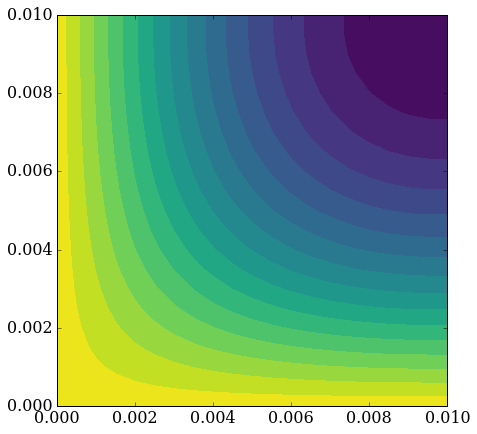

In [43]:
pyplot.figure(figsize=(7,7))
pyplot.contourf(x,y,T,20, cmap=cm.viridis);